In [1]:
%matplotlib notebook

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [2]:
np.random.seed(19680801);
np.set_printoptions(suppress=True) # Para evitar la notacion cientifica

### Parámetros del modelo

In [3]:
N = 10000 # Número de partículas
rho = 2 # Densidad
L = np.sqrt(N/rho) # Longitud de la caja principal
R = 1 # Radio cut-off
v0 = 0.5 # Módulo de la velocidad
eta = 0.2 # Ruido
steps = 10000 # Número de pasos que ejecutará el modelo

### Datos del modelo

In [4]:
# PROPIEDADES DE CELDA

n = int(L//R) # Número de celdas a lo largo de un eje, debe ser entero (L/n >= Rc luego n <= L/Rc)

# Este es el número de celdas 1D (a lo largo de un eje) que hay EN LA CAJA GLOBAL
#  ___ ___ ___
# |   |   |   |  
# |___|___|___|  
# |   |   |   |  | 
# |___|___|___|  |  l  El lado de la caja global es L, y el lado de las particiones 
# |   |   |   |        es l >= Rc
# |___|___|___| 
#  ___________
#
#       L

l = L/n # Lado de cada celda

In [5]:
# COORDENADAS

data = np.empty((N,5), dtype=np.float64) # Inicializamos matriz 9Nx5 vacía

#    x | y | n | th | noise |
#  --------------------------  (x,y) son las coordenadas, y n define el número de celda asociado, que va desde
#      |   |   |    |       |  0 (celda inferior-izquierda) hasta el número total de celdas
#      |   |   |    |       |

data[:,:2] = np.random.uniform(0, L, (N,2)) # Coordenadas x,y en las 2 primeras columnas y N filas.


data[:,3] = np.random.uniform(0,2*np.pi,N) # Coordenadas angulares

# ASIGNACIÓN DE ÍNDICES DE CELDA

@nb.njit(parallel=True)
def asigna_celda(data, N, L, l, n):
    """Asignamos celdas al array principal inplace, y de paso construimos una linked list"""
    
    lista = np.zeros(N, dtype=np.int64)
    head = np.zeros(n**2, dtype=np.int64) # Array con los índices de la última partícula
                                                         # p.e head[5] nos dará el índice de la última
                                                         # partícula de la celda 5
    for i in nb.prange(N):
        data[i,2] = data[i,0]//l + data[i,1]//l*n # Asignamos índice de celda
        lista[i] = head[int(data[i,2])]
        head[int(data[i,2])] = i
    return head, lista

head, lista = asigna_celda(data, N, L, l, n)

#------Ruidos y orden---------------------

data[:,4] = np.random.uniform(-np.pi, np.pi, N) # Ruido, de -pi a pi

### Funciones auxiliares

Relación entre índice de celda (cell) y coordenadas de celda (x,y):
$$\text{cell} = x\ \% \ n+y\cdot n$$

$$x = \text{cell}\ \%\ n \\ y = \text{cell}\ //\ n  $$
donde $n$ es el número de celdas a lo largo de un eje

In [6]:
@nb.njit(nb.i8[:](nb.i8, nb.i8), fastmath=True)
def celdas_vecinas(cell,n):
    """Dado un índice de celda (cell) y el número de celdas que hay a lo largo de un eje (n),
    devuelve un array con los índices de las celdas vecinas"""
    
    if n == 1: # Solo hay una celda, entonces es la 0
        return np.array([0])
    elif n == 2: # Solo hay 4 celdas y todas son vecinas
        return np.array([0, 1, 2, 3])
    elif n <= 0:
        raise ValueError('El número de celdas a lo largo de un eje debe ser igual o superior a 1.')
    
    Nt = n**2 # Número total de celdas
    assert cell < Nt, 'El índice de celda no puede superar el número total de celdas'
    
    x = cell % n; y = cell // n # Coordenadas x e y de celda
    izq =      (x - 1) % n + y * n
    der =      (x + 1) % n + y * n
    arri =     (x % n + (y+1) * n) % Nt
    aba =      (x % n + (y-1) * n) % Nt
    aba_izq =  (izq - n) % Nt
    aba_der =  (der - n) % Nt
    arri_izq = (izq + n) % Nt
    arri_der = (der + n) % Nt
    
    return np.array([cell, aba_izq, aba, aba_der, izq, der, arri_izq, arri, arri_der])

In [7]:
@nb.njit(nb.types.UniTuple(nb.i8,3)(nb.i8,nb.i8,nb.i8), fastmath=True)
def distance(a, b, n):
    """Computa la distancia entre las celdas de índices a y b, siendo n
    el número de celdas a lo largo de un eje. n^2 es el número total de celdas.
    La idea al devolver el signo de la diferencia de coordenadas es luego utilizar dicha información
    para realizar un traslado de partículas en celdas vecinas pero distantes"""
    
    def div(a,b): # Hay que definir la división entera para negativos
        return -(-a // b) if a < 0 else a // b
    
    x1 = a%n;  x2 = b%n; # Coordenadas x de celda
    y1 = a//n; y2 = b//n # Coordenadas y de celda
    dx = x2 - x1
    dy = y2 - y1
    return max(abs(dx), abs(dy)), np.sign(div(dx,2)), np.sign(div(dy,2))
    # Habrá que hacer un traslado de coordenadas si la diferencia de coordenadas es superior a 2

### Función paso

In [8]:
@nb.njit(nb.types.Tuple([nb.f8[:,:],nb.i8[:],nb.i8[:]])
        (nb.f8[:,:],nb.i8[:],nb.i8[:],nb.i8,nb.f8,nb.i8,nb.f8,nb.f8),
         parallel=True, fastmath=True) # Para simulaciones poner parallel=False, para animacion True
def step(data, head, lista, N, L, n, v0, eta):
    
    out = np.empty(data.shape, dtype=data.dtype) # El out es un array de datos de salida tras el paso. 
                                                 # con sus mismas dimensiones
        
    lista_out = np.zeros(N, dtype=np.int64) # Inicializamos lista y headers de salida
    head_out = np.zeros(n**2, dtype=np.int64)
    
    for i in nb.prange(N): # Bucle a las partículas
        
        s = np.exp(1j*data[i,3]) # Esta variable llevará la suma de angulos de los vecinos
                                 # para cada partícula. La inicializamos con el ángulo de la propia i
        cell = int(data[i,2]) # Cogemos la celda de la partícula como número entero
        vecinos = celdas_vecinas(cell, n)# Calculamos celdas vecinas
        # Calculamos las celdas vecinas, incluida la misma
        
        for vec in vecinos: # Bucle a las celdas vecinas
            dis, dx, dy = distance(cell, vec, n) # Distancia entre celdas cell y vec
            j = head[vec] # Cogemos el índice de la última partícula en la celda vec
            while j: # Mientras queden partículas en la celda
                if dis < 2: # Si las celdas se encuentran a una distancia menor a 2 entonces son contiguas,
                            # no habrá que aplicar correcciones
                    diff = (data[i,0] - data[j,0])**2 + (data[i,1] - data[j,1])**2 # Calculamos distancia 
                                                                                   # entre la partícula i y j
                    if diff < R**2: # Si la distancia es < R
                        s += np.exp(1j*data[j,3]) # Añadimos la exponencial del ángulo a la variable s
                else: # En caso de que se trate de celdas no contiguas (aunque vecinas), hay que corregir
                    diff = (data[i,0] - (data[j,0]-dx*L))**2 + (data[i,1] - (data[j,1]-dy*L))**2
                    if diff < R**2: # Si la distancia es < R
                        s += np.exp(1j*data[j,3]) # Añadimos la exponencial del ángulo a la variable s
                j = lista[j] # ponemos j como el índice de la siguiente partícula
                
        # Construcción del array de salida            
        out[i,3] = np.arctan2(s.imag, s.real) + eta*data[i,4] # Actualizamos ángulos primero
        
        out[i,0] = np.mod(data[i,0] + np.cos(out[i,3])*v0, L ) # Actualizamos posiciones x en caja principal
        out[i,1] = np.mod(data[i,1] + np.sin(out[i,3])*v0, L ) # Actualizamos posiciones y en caja principal
        # Actualizamos posiciones y en caja principal
        
        out[i,2] = out[i,0]//l + out[i,1]//l*n
        lista_out[i] = head_out[int(out[i,2])]
        head_out[int(out[i,2])] = i
    out[:,4] = np.random.uniform(-np.pi, np.pi, N)
    
    return out, head_out, lista_out

In [9]:
%timeit step(data, head, lista, N, L, n, v0, eta)

5.1 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Animación

<IPython.core.display.Javascript object>


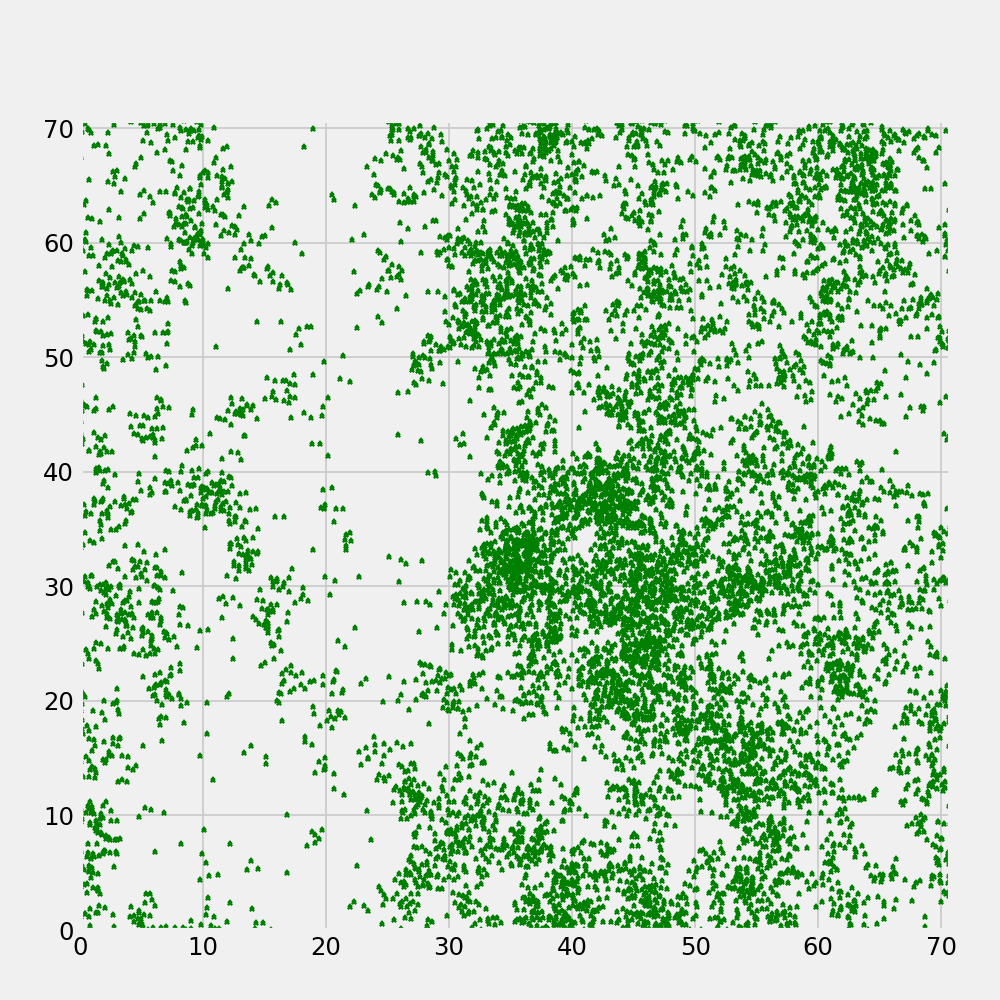

In [10]:
plt.style.use('fivethirtyeight')

class Anima:
    
    def __init__(self, data, head, lista, N, L, n, v0, eta):
        
        self.fig = plt.figure(figsize=(8,8))
        self.ax = plt.axes(xlim=(0, L), ylim=(0, L))
        self.line, = self.ax.plot([], [],'*g',markersize=3)
        self.data = data
        self.head = head
        self.lista = lista
        self.N = N
        self.L = L
        self.n = n
        self.v0 = v0
        self.eta = eta
        
    def init(self):
        
        self.line.set_data([self.data[:, 0]], [self.data[:, 1]])
        return self.line,
    
    def update(self,i):
        
        self.data, self.head, self.lista = step(self.data, self.head, self.lista, self.N, self.L,
                                               self.n, self.v0, self.eta)
        self.x = self.data[:, 0]
        self.y = self.data[:, 1]
        self.line.set_xdata(self.x)
        self.line.set_ydata(self.y)
        return self.line,
    
    def animate(self):
        
        self.ani = FuncAnimation(self.fig, self.update, init_func=self.init,
                                 frames=steps, interval=1, blit=True, repeat=False)
        
obj = Anima(data, head, lista, N, L, n, v0, eta)
obj.animate()
plt.show()

### Simulación